### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [17]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
# import data handling class
from DT5550 import *

In [46]:
#tcorr = -np.array([0,-11,4.5,-21,46,-38,-59,-41])
#tcorr = -np.array([0,-105,-131,-122,-208,-120,-61,-89])
tcorr = np.array([0, 0, 0, 0, 0, 0, 0, 0])
#gcorr = np.array([1,1,1,1,0.955,1,1,1])
gcorr = np.array([1,1,1,1,1,1,1,1])
#rcorr = np.array([1,1,0.989,0.9734,1.070,0.997,1.009,0.9446])
rcorr = np.array([0.,1.,1.00990835,0.98526133,1.09747337,1.00780282,1.02724796,0.96321526])

In [47]:
def four_gamma():
    if io.valid.sum() == 4:
        esum = 0
        nsum = 0
        tav  = 0
        tlist = []
        for idet in range(N_DETECTOR):
            E = io.Q[idet]
            if io.valid[idet]:
                if (E>1100) and (E<1350):
                    isel = idet
                    tsel = io.t[idet]
                else:
                    esum = esum + io.Q[idet]
                    tlist.append(io.t[idet])
                    nsum = nsum + 1
        
        if nsum==3:
            tlist = np.array(tlist)
            tav = tlist.mean()
            tstd = np.sqrt(tlist.var())
            E1.append(tstd)
            #print(tstd)
            if tstd<100 and tsel<tav and esum>800 and esum<1200:
                E0.append(esum)
                t0.append(tsel)
                t1.append(tav)

                
                
def two_gamma():
    #
    # 
    #
    
    #
    # demand two valid hits
    #
    if io.valid.sum() == 2:
        idet_sel = []
        #
        # get the indices of the two hits 
        #
        for idet in range(N_DETECTOR):
            if io.valid[idet]:
                idet_sel.append(idet)
        
        #
        # select events in which idet=0 detected an 1173keV gamma
        #

        
        idet_sel = np.array(idet_sel)
        
        if idet_sel[0] == 0 and len(idet_sel) == 2:
            id0 = idet_sel[0]
            id1 = idet_sel[1]
            delta_t[id1].append(io.tc[id1]-io.tc[id0]-(tcorr[id0]-tcorr[id1]))
        
        if len(idet_sel) >= 2:
            E0.append(io.Q[idet_sel[0]])
            E1.append(io.Q[idet_sel[1]])
            t0.append(io.t[idet_sel[0]]-tcorr[idet_sel[0]])
            t1.append(io.t[idet_sel[1]]-tcorr[idet_sel[1]])
            t0c.append(io.tc[idet_sel[0]]-tcorr[idet_sel[0]])
            t1c.append(io.tc[idet_sel[1]]-tcorr[idet_sel[1]])
        
def correlation():
    #
    # Co60 angular correlation study
    #
    
    #
    # demand two valid hits
    #
    Ed = np.zeros(N_DETECTOR)
    Ed_old = np.zeros(N_DETECTOR)
    
    if io.valid.sum() == 2:
        idet_sel = []
        #
        # get the indices of the two hits 
        #
        Ed = io.Q * gcorr
        Ed_old = io.Qold * gcorr


        for idet in range(N_DETECTOR):
            if io.valid[idet]:
                idet_sel.append(idet)
        
        i0 = idet_sel[0]
        i1 = idet_sel[1]
        Es_loose.append(io.Q[i0]+io.Q[i1])
        #
        # select events with a 1173keV gamma ray in detector=0
        #
        if i0 == 0 and Ed[i0]<1250:
            esel[i0].append(Ed[i0])
            
        if Ed[i0]>1000 and Ed[i0]<1300:
            ecal[i0].append(Ed[i0])
        if Ed[i1]>1000 and Ed[i1]<1300:
            ecal[i1].append(Ed[i1])

        if i0 == 0 and Ed[i0]>1100 and Ed[i0]<1250 and abs(io.tc[i0] - io.tc[i1])<10.:
            #
            # select the 1330keV gamma ray in one of the other detectors
            #
            esel[i1].append(Ed[i1])

            if Ed[i1] > 1250 and Ed[i1] < 1500:
                    nsum[i1] = nsum[i1]+1
                    Es.append(Ed[i0]+Ed[i1])
            #
            # see if there is a random match of a 1337keV event from the previous event
            #
            for i in range(1,N_DETECTOR):
                if Ed_old[i] > 1250 and Ed_old[i] < 1500 and io.valid_old.sum() == 2:
                    nsum_ran[i] = nsum_ran[i]+1

    
    
    #
    # overwrite Ed_old
    #
    Ed_old = Ed
    nvalid_old = io.valid.sum()

Filename to process

Open a datafile and read the data

In [48]:
#
# open the datfile
#
#io = DT5550(indir='C:/data/20211221_150523/')
    
io = DT5550(indir='C:/data/20220103_162243/')
t0 = []
t1 = []
t0c = []
t1c = []
E0 = []
E1 = []
Es = []
Es_loose = []

nmax = 5
ifile = 0

nsum = np.zeros([N_DETECTOR])
nsum_ran = np.zeros([N_DETECTOR])

delta_t = [[] for i in range(N_DETECTOR)]
esel = [[] for i in range(N_DETECTOR)]
ecal = [[] for i in range(N_DETECTOR)]



for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        #
        #
        #
        
        if io.n_event%100000 == 0:
            print('Processed ',io.n_event,' events')
        # four gamma analysis    
        #####four_gamma()    
        # timing performance
        two_gamma()
        # correlation in Co60
        correlation()
    ifile = ifile +1
    if ifile>nmax:
        break
    
t0 = np.array(t0)
t1 = np.array(t1)
t0c = np.array(t0c)
t1c = np.array(t1c)
E0 = np.array(E0)
E1 = np.array(E1)

Es = np.array(Es)
Es_loose = np.array(Es_loose)
delta_t = np.array(delta_t, dtype=object)
esel = np.array(esel, dtype=object)
ecal = np.array(ecal, dtype=object)


print('Processing done')

DT5550:: Data recorded with config:  C:/data/20220103_162243\config_20220103_162243.json
DT5550:: Open data file: C:/data/20220103_162243\data_20220103_162243_0.raw
Processing done


A few basic plots: integrated charge and time

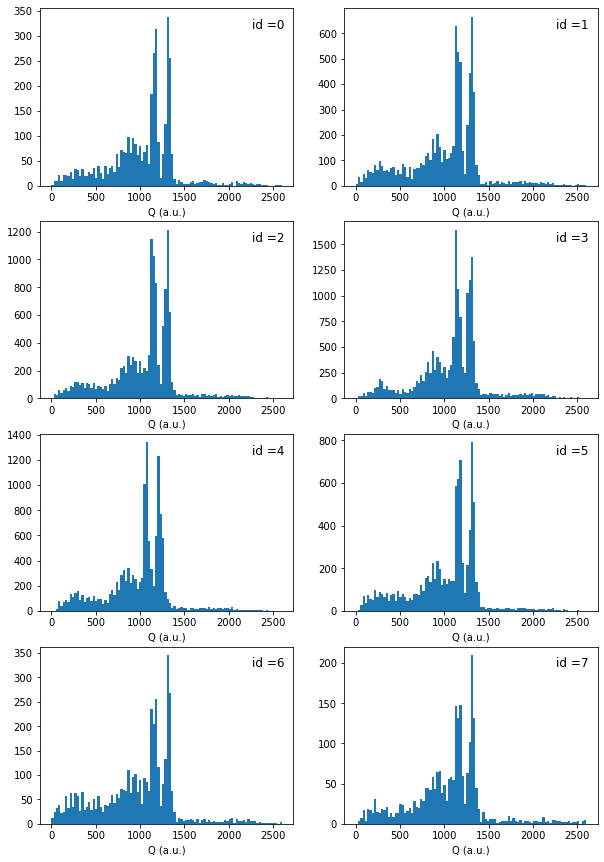

In [49]:
io.plot_all(type="charge",bins=100,logy=False, range=(0,2600))

In [50]:
# io.plot_all(type="time",range=(200,600),bins=100,logy=True)

149.91429150053068


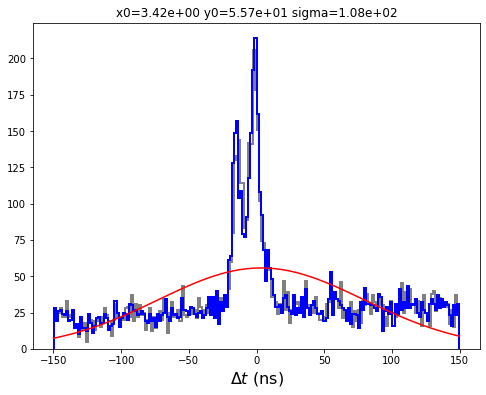

In [52]:
from scipy.optimize import curve_fit

plt.figure(figsize=(8,6))
dtmax = 150
dt_nocorr = (t0-t1)
dt_nocorr = dt_nocorr[abs(dt_nocorr)<dtmax]

dt = (t0c-t1c)
dt = dt[abs(dt)<dtmax]

bins = 200
y, xe  = np.histogram(dt,bins=bins)
x = .5 * (xe[:-1] + xe[1:])
print(xe[-1])

# Function to be fitted
def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

# Initialization parameters
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=p0)

# Plot the results
plt.title('x0=%.2e y0=%.2e sigma=%.2e' % (fit[0], fit[1], fit[2]))
# Data
plt.hist(dt_nocorr,bins=bins, histtype='step',linewidth=2,color='grey')
plt.hist(dt,bins=bins,histtype='step',linewidth=2,color='blue')

#plt.plot(x, y, drawstyle='steps', color='blue',linewidth=2)
# Fitted function
x_fine = np.linspace(xe[0], xe[-1], 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'r-')

plt.xlabel('$\Delta t$ (ns)',fontsize=16)
plt.yscale('linear')
#plt.ylim(10,15000)

plt.savefig('Gaussian_fit.png')


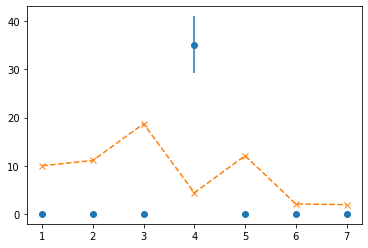

In [8]:
x = np.arange(1,8)
y = nsum[1:8]*rcorr[1:8]
yr = nsum_ran[1:8]*rcorr[1:8]
err = np.sqrt(y)
#print(x,y,err)
plt.errorbar(x, y, yerr=err, marker='o', ls='')
plt.plot(x,yr,'x--')

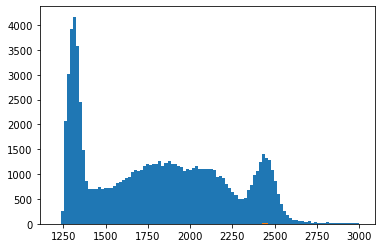

In [9]:
h = plt.hist(Es_loose,range=(1200,3000),bins=100)
h = plt.hist(Es,range=(1200,3000),bins=100)

plt.yscale('linear')

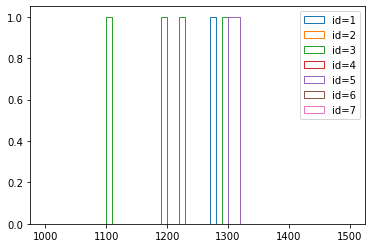

In [53]:
for i in range(1,N_DETECTOR):
    txt = 'id='+str(i)
    h = plt.hist(esel[i], bins=50, range=(1000,1500), histtype = 'step', label = txt)
    
plt.legend()
    
plt.yscale('linear')


1 -9.640461645294888
2 -2.1995202731322707
3 -10.797359145454273
4 -45.768416415934276
5 74.907214529396
6 62.154707171294994
7 -87.39197505248703


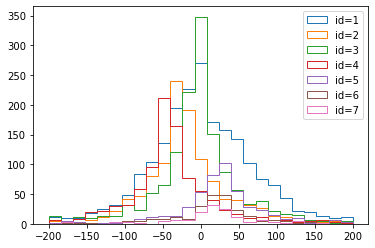

In [11]:
for i in range(1,8):
    txt = 'id='+str(i)
    h = plt.hist(delta_t[i],bins=25,range=(-200,200), histtype='step', label = txt)
    dt = np.array(delta_t[i])
    print(i,dt.mean())
plt.legend()

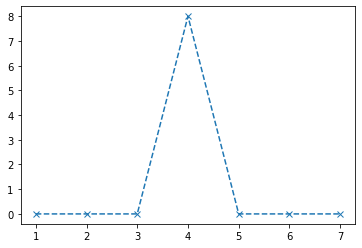

In [12]:
plt.plot(x,y/yr,'x--')

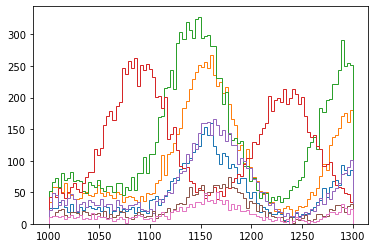

In [13]:
for i in range(1,8):
    h = plt.hist(ecal[i],bins=100,histtype='step',range=(1000,1300))

[0.         1.         1.89483195 2.23274304 1.07228045 1.25225876
 0.50957716 0.30357788]


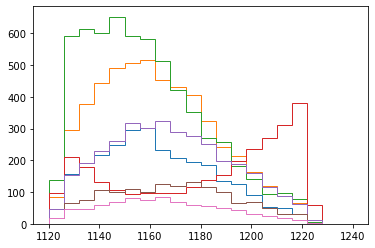

In [14]:
rcorr = np.zeros(N_DETECTOR)
for i in range(1,8):
    ee = np.array(ecal[i])
    ee = ee[abs(ee-1173)<50]
    rcorr[i] = len(ee)
    h = plt.hist(ee,bins=20,histtype='step',range=(1120,1240))

print(rcorr/rcorr[1])